# Adaptive PDE discretizations on cartesian grids

## Part : Optimal transport
## Chapter : The Monge-Ampere equation

This notebook presents a series of methods for numerically solving the Monge-Ampere equation
$$
    f(x) - \det(\nabla^2 u(x)) = 0,
$$
among convex functions, with Dirichlet boundary conditions. 
The function $f$ is assumed to be strictly positive.
For that purpose, we rely on the monotone and consistent MA-LBR numerical scheme (Monge-Ampere using Lattice Basis Reduction), and some variants.

**References.**

The MA-LBR scheme was first introduced in:
* Benamou, J.-D., Collino, F., & Mirebeau, J.-M. (2016). Monotone and Consistent discretization of the Monge-Ampere operator. Mathematics of Computation, 85(302), 2743–2775.

**Reformulation as an extremal operator.**
The starting point of these methods is to observe that, for a positive definite $d \times d$ matrix $M$
$$
    d ({\rm det} M)^\frac 1 d = \inf_{{\rm det} D = 1} {\rm tr}(D M),
$$
where, implicitly, the optimization variable $D$ is also assumed to be a symmetric positive definite matrix.

If $M = \nabla^2 u$ is a hessian matrix, then the l.h.s. is (a multiple of a power of) the Monge-Ampere operator, while the r.h.s. is an infimum of second order linear operators, which can be discretized using monotone finite differences.

**Discretization strategy**
The chosen finite difference scheme for the linear operator is described in 
[I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)
Since 


[**Summary**](Summary.ipynb) of this series of notebooks. 
[**Main summary**](../Summary.ipynb), including the other volumes of this work. 

# Table of contents
  * [1. Naive non-monotone discretization (purposedly fails)](#1.-Naive-non-monotone-discretization-(purposedly-fails))
  * [2. The MA-LBR scheme](#2.-The-MA-LBR-scheme)
    * [2.1 First implementation](#2.1-First-implementation)
    * [2.2 Optimized implementation](#2.2-Optimized-implementation)
  * [3. Uniformly elliptic scheme](#3.-Uniformly-elliptic-scheme)
    * [3.1 First implementation](#3.1-First-implementation)
    * [3.2 Optimized implementation](#3.2-Optimized-implementation)
    * [3.3 Validation](#3.3-Validation)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [ ]:
import sys; sys.path.append("..") # Allow imports from parent directory
#from Miscellaneous import TocTools; TocTools.displayTOC('MongeAmpere','NonDiv')

In [3]:
from NumericalSchemes import Selling
from NumericalSchemes import Domain
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import AutomaticDifferentiation as ad

In [4]:
import numpy as np
from matplotlib import pyplot as plt

Some utility functions

In [6]:
newton_root = ad.Optimization.newton_root
stop    = ad.Optimization.stop_default
damping = ad.Optimization.damping_default 

In [8]:
def reload_packages():
    import importlib
    Selling = importlib.reload(sys.modules['NumericalSchemes.Selling'])
    Domain = importlib.reload(sys.modules['NumericalSchemes.Domain'])
    lp = importlib.reload(sys.modules['NumericalSchemes.LinearParallel'])
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.reload_submodules()

In [9]:
figSaveDir = None #"Figures/MongeAmpere/"

## 1. Naive non-monotone discretization (purposedly fails)

We present a naive, non-monotone discretization of the addressed problem. This scheme can be used to check that a numerical solution (produced by other means) is correct, or to construct synthetic examples. However, using it to solve the PDE is usually bound to fail. 

The naive scheme is based on a reconstruction of the Hessian matrix of the form
$$
    \begin{pmatrix}
        D^h_{00} u(x) & D^h_{01} u(x)\\
        D^h_{01} u(x) & D^h_{11} u(x)
    \end{pmatrix},
$$
where $D_{00}$, $D_{01}$ and $D_{11}$ are finite-difference operators. Namely
$$
    D^h_{00} u(x) := \frac{u(x_0+h,x_1)-2 u(x_0,x_1) + u(x_0-h,x_1)}{h^2},
$$
likewise for $D^h_{11} u(x)$, and finally
$$
    D^h_{01} u(x) := \frac{u(x_0+h,x_1+h)-u(x_0-h,x_1+h)-u(x_0+h,x_1-h)+h(x_0-h,x_1-h)}{4 h^2}.
$$

In [10]:
def SchemeNonMonotone(u,f,bc):
    # Compute the hessian matrix of u
    uxx = bc.Diff2(u,(1,0))
    uyy = bc.Diff2(u,(0,1))
    uxy = 0.25*(bc.Diff2(u,(1,1)) - bc.Diff2(u,(1,-1)))
    
    # Numerical scheme
    det = uxx*uyy-uxy**2
    residue = f - det
    
    # Boundary conditions
    return ad.where(bc.interior,residue,u-bc.grid_values)

We next choose some problem parameters

In [57]:
# Create the domain
aX0 = np.linspace(-1,1,100); aX1=aX0;
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))

# Set the boundary conditions 
gridscale = aX0[1]-aX0[0]
bc = Domain.MockDirichlet(X.shape[1:],gridscale,padding=0.)

bc_convex = Domain.Dirichlet(Domain.Union((Domain.Ball(),Domain.Box())), 0., X)
bc_concave = Domain.Dirichlet(Domain.Complement(Domain.Ball(),Domain.Box()), 0., X)

# Choose the PDE parameters
f=1.

In [58]:
guess_quadratic = X[0]**2+X[1]**2 -2.

The naive and non-monotone discretization scheme is consistent, but lacks any other sort of theoretical guarantees. 

**In general, attempts to solve numerically the non-monotone scheme will fail. This is expected behavior**

The non-monotone scheme may nevertheless work for some specific gentle problem instances (with a smooth solution), a careful initialization, and a bit of luck. This is the case below.

<!---This is the case below, where we solve the same problem as above, but with a different handling of the boundary conditions: they are imposed implicitly by the padding values used in the finite differences.--->

In [59]:
params = (f,bc_convex)
solution_non_monotone = newton_root(SchemeNonMonotone,guess,params) 

plt.axis('equal'); plt.title("Solution to 1-det(d^2 u)=0, with u=0 on bd")
plt.contourf(*X,solution_non_monotone);

Iteration: 1  Residue norm: 5443032.737824348
Iteration: 2  Residue norm: 1360754.4136828298
Iteration: 3  Residue norm: 340170.4766855266
Iteration: 4  Residue norm: 307030.6441118047
Iteration: 5  Residue norm: 453433.5543942774
Iteration: 6  Residue norm: 801489.1894838014
Iteration: 8  Residue norm: 74335.24708171454
Iteration: 10  Residue norm: 109194.22105146274
Iteration: 12  Residue norm: 458178.4010735697
Iteration: 14  Residue norm: 47249743.98982264
Iteration: 16  Residue norm: 2949472.5300567965
Iteration: 20  Residue norm: 70983.7756075758
Iteration: 24  Residue norm: 1796872.9184689848
Iteration: 28  Residue norm: 6121919460.667867
Iteration: 32  Residue norm: 23913728.885781102
Iteration: 36  Residue norm: 172098954.87434092
Iteration: 40  Residue norm: 2560970.252021373
Iteration: 44  Residue norm: 95458.25811342511
Iteration: 48  Residue norm: 27984766.798518207
Iteration: 50  Residue norm: 1748763.7101704653
Max iterations exceeded. Aborting.


ValueError: 

## 2. The MA-LBR scheme

The MA-LBR scheme is a monotone and consistent discretization of the Monge-Ampere operator. It takes the form:
$$
    \Lambda u(x) := \inf_{(e_0,e_1,e_2) \in S} H( \Delta_{e_0}^h u(x), \Delta_{e_1}^h u(x), \Delta_{e_2}^h u(x)).
$$
We denoted by $S$ a family of superbases of $Z^2$, which is a parameter to the scheme that must be chosen, see below. 
Superbases are triplets $(e_0,e_1,e_2)$ of vectors $e_0,e_1,e_2 \in Z^2$ with integer coordinates.

We denoted second order finite differences, in a direction $e\in Z^2$ by 
$$
    \Delta_e^h u(x) := \frac{u(x+h e) -2 u(x) +u(x+he)} {h^2}.
$$
The scheme also features a three argument function $H$, defined as follows: $H(a,b,c) := H_0(a_+,b_+,c_+)$, where 
$$
    H_0(a,b,c) :=
    \begin{cases}
        a b \quad \text{ if }\ a+b < c, \text{ and likewise permuting } a,b,c\\
        \frac 1 2 (a b+b c+c a) - \frac 1 4 (a^2+b^2+c^2)\quad \text{ otherwise}.
    \end{cases}
$$


**Convexity of the solution, and ellipticity of the PDE and numerical scheme.**

The Monge-Ampere equation imposes, as a constraint, that the solution $u$ be convex. The ellipticity of the Monge-Ampere operator degenerates as $\det(\nabla^2 u) \to 0$, which means that $u$ looses convexity.

A similar issue arises with the MA-LBR scheme. It is strictly elliptic only as long as 
$$
    \Lambda u(x) > 0,
$$
which is a discrete counterpart of convexity. 

**Damping of the Newton method.**
We need to guarantee that, along the iterations, the numerical scheme ellipticity is preserved. 
A first requirement for this is to choose a strictly convex initialization, for instance the quadratic function $u(x) = \|x\|^2/2$.

For this reason, we also resort to a damped Newton method. The default behavior is to define
$$
    u_{n+1} = u_n + 2^{-k_n} d_n,
$$
where $d_n$ is the Newton descent direction, and $k_n$ is the least integer such that 
$$
    \Lambda u_{n+1}(x) \geq f(x)/2,
$$
at all discretization points $x$.
(Recall that the r.h.s $f$ is assumed to be strictly positive.)

We assume, for simplicity, that this condition holds at initialization. Otherwise a threshold lower than $f/2$ could be used.

### 2.1 First implementation

In [33]:
def MALBR_H(d2u):
    a,b,c = ad.sort(np.maximum(0.,d2u), axis=0)
    
    # General formula, handling infinite values separately
    A,B,C = (ad.where(e==np.inf,0.,e) for e in (a,b,c))
    result = 0.5*(A*B+B*C+C*A)-0.25*(A**2+B**2+C**2)
    
    pos_inf = np.logical_or.reduce(d2u==np.inf)    
    result[pos_inf]=np.inf
    
    pos_ineq = a+b<c
    result[pos_ineq] = (A*B)[pos_ineq]
        
    return result
    
def SchemeMALBR(u,SB,f,bc):
    # Compute the finite differences along the superbase directions
    d2u = bc.Diff2(u,SB)
    
    # Numerical scheme
    residue = f-MALBR_H(d2u).min(axis=0)
    
    # Boundary conditions
    return ad.where(bc.interior,residue,u-bc.grid_values)

We next implement the test used to select the damping parameter, as announced. 

In [34]:
def InvalidMALBR(u,SB,f,bc):
    residue = SchemeMALBR(u,SB,f,bc)
    return np.any(residue[bc.interior]>=f/2)

We next choose a family of superbases. The scheme is (second order) consistent while the condition number of the hessian of $u$ remains below the given bound. Beyond that, a consistency defect is introduced.

In [35]:
SB0 = Selling.SuperbasesForConditioning(5)
SB1 = Selling.SuperbasesForConditioning(15)
SB2 = Selling.SuperbasesForConditioning(30)

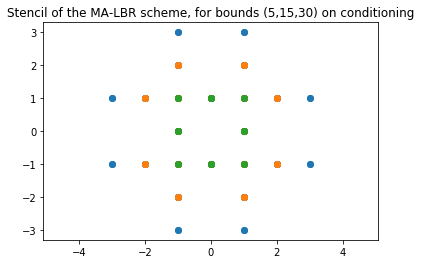

In [36]:
plt.axis('equal'); plt.title('Stencil of the MA-LBR scheme, for bounds (5,15,30) on conditioning')
def stencil(SB): return np.stack((SB,-SB),axis=2)[:,:]
plt.scatter(*stencil(SB2));plt.scatter(*stencil(SB1));plt.scatter(*stencil(SB0));

In [28]:
#bc2_grid_values = np.zeros(bc.shape); bc2_grid_values[1:-1,1:-1]=np.nan
#bc2 = Domain.MockDirichlet(bc2_grid_values,gridscale,padding=np.inf)

The initial guess is chosen to be in the ellipticity domain of the operator.

In [49]:
InvalidMALBR(guess_quadratic,SB0,f,bc)

False

In [60]:
%%time
# This damping rule cuts the step size in half until the MALBR validity criterion is met
dampingMALBR = damping(criterion=InvalidMALBR)

params = (SB0,f,bc_convex)
solution_MALBR = newton_root(SchemeMALBR,guess_quadratic,params,damping=dampingMALBR)

../NumericalSchemes/AutomaticDifferentiation/Sparse.py:214: RuntimeWarning: invalid value encountered in less
  return super(spAD,self).__array_ufunc__(ufunc,method,*inputs_,**kwargs)
/Users/mirebeau/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


Iteration: 1  Residue norm: 2653538.125096021
Iteration: 2  Residue norm: 1492615.132734855
Iteration: 3  Residue norm: 1142783.445332539
Iteration: 4  Residue norm: 874943.5596608937
Iteration: 5  Residue norm: 669878.6471891344
Iteration: 6  Residue norm: 512875.8235732176
Iteration: 8  Residue norm: 162277.0179616761
Iteration: 10  Residue norm: 51345.36443083085
Iteration: 12  Residue norm: 16245.895702178128
Iteration: 14  Residue norm: 5140.204199218046
Iteration: 16  Residue norm: 1626.2937254400497
Iteration: 20  Residue norm: 301.5446765192108
Iteration: 24  Residue norm: 40.86154993450933
Iteration: 28  Residue norm: 0.322269487306416
Iteration: 31  Residue norm: 7.32040206230522e-10
Target residue reached. Terminating.
CPU times: user 33.3 s, sys: 2.96 s, total: 36.3 s
Wall time: 9.12 s


The last Newton steps, close to the solution, equal one. In contrast, a stong damping is applied in some of the first. 

In [61]:
np.array(dampingMALBR.steps)

array([0.5 , 0.5 , 0.25, 0.25, 0.25, 0.25, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.25, 0.25, 0.25, 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 1.  , 1.  , 1.  , 1.  , 1.  ])

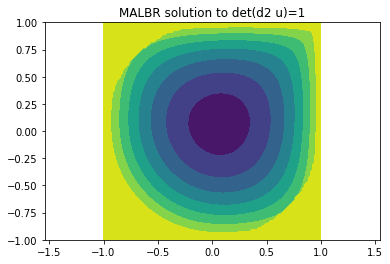

In [62]:
plt.axis('equal'); plt.title("MALBR solution to det(d2 u)=1")
plt.contourf(*X,solution_MALBR);

In [66]:
%%time
# This damping rule cuts the step size in half until the MALBR validity criterion is met
dampingMALBR = damping(criterion=InvalidMALBR)
relax = bc_concave.gridscale*ad.Sparse.identity(bc_concave.shape)

params = (SB0,f,bc_concave)
solution_MALBR = newton_root(SchemeMALBR,guess_quadratic,params,damping=dampingMALBR,relax=relax)

/Users/mirebeau/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


Minimal damping undershot. Aborting.
Iteration: 1  Residue norm: 43974.894315062214
Minimal damping undershot. Aborting.
Iteration: 2  Residue norm: 43829.57143006883
Minimal damping undershot. Aborting.
Iteration: 3  Residue norm: 43690.23755402869
Minimal damping undershot. Aborting.
Iteration: 4  Residue norm: 40265.01568229149
Minimal damping undershot. Aborting.
Iteration: 5  Residue norm: 40148.936771841276
Minimal damping undershot. Aborting.
Iteration: 6  Residue norm: 85989.56226127781
Minimal damping undershot. Aborting.
Minimal damping undershot. Aborting.
Iteration: 8  Residue norm: 85423.31648620582
Minimal damping undershot. Aborting.
Minimal damping undershot. Aborting.
Iteration: 10  Residue norm: 80713.99994616563
Minimal damping undershot. Aborting.
Minimal damping undershot. Aborting.
Iteration: 12  Residue norm: 80342.87153220485
Minimal damping undershot. Aborting.
Minimal damping undershot. Aborting.
Iteration: 14  Residue norm: 79991.03668798052
Minimal damping u

ValueError: 

### 2.2 Optimized implementation

In the course of the Newton method, the AD-LBR scheme is evaluated on sparse AD variables. In this regard, two features of the scheme yield optimization opportunities:
* *Minimization over the superbases.* Using the envelope theorem, we find the minimizer using ordinary arrays without AD information, and then provide this oracle information in a second pass involving AD information.
* *Complex non-linear function $H$.* We can take advantage of dense and sparse AD composition, to efficiently evaluate $H$.

**Important: other optimization opportunities.**
Our main intent in this subsection is to illustrate advanced AD techniques. There may be other optimization opportunities.

In [50]:
def SchemeMALBR_OptInner(u,SB,bc,oracle=None):
    # If the active superbases are known, then take only these
    if not(oracle is None):
        SB = np.take_along_axis(SB,np.broadcast_to(oracle,SB.shape[:2]+(1,)+oracle.shape),axis=2)
                
    d2u = bc.Diff2(u,SB)    
    # Evaluate the complex non-linear function using dense - sparse composition
    result = ad.apply(MALBR_H,d2u,shape_bound=u.shape)
    
    return ad.min_argmin(result,axis=0)

def SchemeMALBR_Opt(u,SB,f,bc):
    
    # Evaluate using the envelope theorem
    result,_ = ad.apply(SchemeMALBR_OptInner, u,bc.as_field(SB),bc, envelope=True)
        
    # Boundary conditions
    return ad.where(bc.interior, f - result, u-bc.grid_values)

We can afford more superbases, taking `SB2` instead of `SB0`, thanks to the optimizations. Replace `SchemeMALBR_Opt` with `SchemeMALBR` to see the computation time difference.

In [55]:
%%time
params = (SB2,f,bc2)
solution_MALBR = newton_root(SchemeMALBR_Opt,3+guess_quadratic,params,damping=dampingMALBR) 

Iteration: 1  Residue norm: 6.148925779842642
Iteration: 2  Residue norm: 5.769782764791206
Iteration: 3  Residue norm: 5.590677363110961
Iteration: 4  Residue norm: 5.417126361126075
Iteration: 5  Residue norm: 5.248957537985855
Iteration: 6  Residue norm: 5.086003958436549
Iteration: 8  Residue norm: 4.624097877440347
Iteration: 10  Residue norm: 3.8102266439252936
Iteration: 12  Residue norm: 2.212385023827651
Iteration: 14  Residue norm: 0.907535513034087
Iteration: 16  Residue norm: 0.25013208967388123
Iteration: 20  Residue norm: 3.9558073505752134e-07
Iteration: 21  Residue norm: 1.9272361484468092e-12
Target residue reached. Terminating.
CPU times: user 18.5 s, sys: 915 ms, total: 19.5 s
Wall time: 4.89 s


In [32]:
%%time
params = (SB2,f,bc,gridScale)
solution_MALBR = newton_root(SchemeMALBR_Opt,guess_quadratic,params,damping=dampingMALBR) 

Iteration: 1  Residue norm: 0.9379882812452407
Iteration: 2  Residue norm: 0.879807207375034
Iteration: 3  Residue norm: 0.8252211483377507
Iteration: 4  Residue norm: 0.7995240309120468
Iteration: 5  Residue norm: 0.7746255779939959
Iteration: 6  Residue norm: 0.7265415012946141
Iteration: 8  Residue norm: 0.6391112504987031
Iteration: 10  Residue norm: 0.49095654566448976
Iteration: 12  Residue norm: 0.4724599455557944
Iteration: 14  Residue norm: 0.3325818923983883
Iteration: 16  Residue norm: 0.4839802854878774
Iteration: 20  Residue norm: 2.2579715874826434e-12
Target residue reached. Terminating.
CPU times: user 19.9 s, sys: 1.01 s, total: 20.9 s
Wall time: 5.3 s


## 3. Uniformly elliptic scheme

We reformulate the PDE as 
$$
    0 = \max_D \det(D)^\frac 1 d - \alpha(x) {\rm tr} (D \nabla ^2 u(x))
$$
subject to the constraints
$$
    D \succeq 0, \qquad {\rm tr} (D) = 1,
$$
and where we denoted
$$
    \alpha(x) := 1/(d f(x)^{\frac 1 d}).
$$

### Reformulation as a quadratic optimization problem

We constrain the above optimization problem to matrices $D$ which can be decomposed over a superbase $(e_0,e_1,e_2)$ of $Z^2$ in the form
$$
    D = \sum_i v_i e_i e_i^T,
$$
where $v_i \geq 0$, $0 \leq i \leq 2$.
We can compute the trace of $D$ 
$$
    {\rm tr}(D) = \sum_i v_i \|e_i\|^2,
$$
and its determinant
$$
    \det(D) = v_0 v_1 + v_1 v_2 + v_2 v_0 = <v,Q v>
$$
where 
$$
    Q = \frac 1 2 \begin{pmatrix} 0 & 1 & 1\\ 1 & 0 & 1\\ 1 & 1 & 0 \end{pmatrix}
$$
In addition, we have the finite differences approximation
$$
    {\rm tr}(D \nabla^2 u(x)) \approx \sum_i v_i \frac{ u(x+h e_i)-2 u(x)+u(x-he_i)} {h^2}
$$


### Solving a low dimensional constrained optimization problem
We need to solve the concave maximization problem 
$$
    \max_v \sqrt{<v,Q v>} + <l,v>
$$
subject to the constraints
$$
    v \succeq 0, \qquad <m,v>=1.
$$

Assuming the positivity constraints are inactive at the maximizer, we obtain the optimality relation
$$
    \frac {Q v}{\sqrt{<v,Q v>}} + l = \mu m,
$$
for some Lagrange multiplier $\mu \in R$.

**Solving the problem.**
A quadratic equation obeyed by this multiplier
$$
    <(\mu m -l), Q^{-1} (\mu m -l)> = 1.
$$
(Which root is to be selected ?)
The minimizer can be obtained by 
$$
    \frac{v}{\sqrt{<v,Q v >}} = Q^{-1} (\mu m -l)
$$

### 3.1 First implementation

In [33]:
def ConstrainedMaximize(Q,l,m):
    dim = l.shape[0]
    if dim==1:
        return (l[0]+np.sqrt(Q[0,0]))/m[0]
    
    # Discard infinite values, handled afterwards
    pos_bad = l.min(axis=0)==-np.inf
    L = l.copy(); L[:,pos_bad]=0
    
    # Solve the quadratic equation
    A = lp.inverse(Q)    
    lAl = lp.dot_VAV(L,A,L)
    lAm = lp.dot_VAV(L,A,m)
    mAm = lp.dot_VAV(m,A,m)
    
    delta = lAm**2 - (lAl-1.)*mAm
    pos_bad = np.logical_or(pos_bad,delta<=0)
    delta[pos_bad] = 1.
    
    mu = (lAm + np.sqrt(delta))/mAm
    
    # Check the positivity
#    v = dot_AV(A,mu*m-L)
    rm_ad = np.array
    v = lp.dot_AV(rm_ad(A),rm_ad(mu)*rm_ad(m)-rm_ad(L))
    pos_bad = np.logical_or(pos_bad,np.any(v<0,axis=0))
    
    result = mu
    result[pos_bad] = -np.inf
    
    # Solve the lower dimensional sub-problems
    # We could restrict to the bad positions, and avoid repeating computations
    for i in range(dim):             
        axes = np.full((dim),True); axes[i]=False
        res = ConstrainedMaximize(Q[axes][:,axes],l[axes],m[axes])
        result = np.maximum(result,res)
    return result

In [34]:
def SchemeUniform(u,SB,f,bc,h):
    # Compute the finite differences along the superbase directions
    d2u = fd.Diff2(u,SB,h) #,padding=np.inf)
    
    # Generate the parameters for the low dimensional optimization problem
    Q = 0.5*np.array([[0,1,1],[1,0,1],[1,1,0]])
    dim = 2
    l = -d2u/(dim * f**(1/dim))
    m = (SB**2).sum(0)

    # Evaluate the numerical scheme
    m = as_field(m,u.shape)
    Q = as_field(Q,m.shape[1:])
    residue = ConstrainedMaximize(Q,l,m).max(axis=0)
    
    # Boundary conditions
    return ad.where(np.isnan(bc),residue,u-bc)

In [35]:
%%time
params = (SB0,f,bc,gridScale)
solution_Uniform = newton_root(SchemeUniform,guess_quadratic,params) 

Iteration: 1  Residue norm: 1.9461602823015034
Iteration: 2  Residue norm: 0.31929227132988736
Iteration: 3  Residue norm: 0.2509001683967279
Iteration: 4  Residue norm: 0.03665041515806805
Iteration: 5  Residue norm: 0.004386125288393883
Iteration: 6  Residue norm: 0.00025531192261918356
Iteration: 8  Residue norm: 1.9161117137400652e-11
Target residue reached. Terminating.
CPU times: user 35 s, sys: 5.2 s, total: 40.2 s
Wall time: 10.1 s


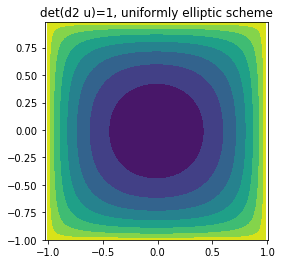

In [55]:
fig = plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title("det(d2 u)=1, uniformly elliptic scheme")
plt.contourf(X0,X1,solution_Uniform);

In [56]:
if figSaveDir: fig.savefig(figSaveDir+'UniformScheme_rhs=1.png')

### 3.2 Optimized implementation

We optimize the uniformly elliptic scheme using the same ingredients as for the MA-LBR scheme: the envelope theorem, and dense-sparse AD composition.

In [37]:
def SchemeUniform_OptInner(u,SB,f,h,oracle=None):
    # Use the oracle, if available, to select the active superbases only
    if not(oracle is None):
        SB = np.take_along_axis(SB,np.broadcast_to(oracle,SB.shape[:2]+(1,)+oracle.shape),axis=2)

    d2u = fd.Diff2(u,SB,gridScale) 
    
    # Generate the parameters for the low dimensional optimization problem
    Q = 0.5*np.array([[0,1,1],[1,0,1],[1,1,0]])
    dim = 2
    l = -d2u/(dim * f**(1/dim))
    m = (SB**2).sum(0)

    
    m = as_field(m,u.shape)
    Q = as_field(Q,m.shape[1:])
    
    # Evaluate the non-linear functional using dense-sparse composition
    result = ad.apply(ConstrainedMaximize, Q,l,m, shape_bound=u.shape)
    
    return ad.max_argmax(result,axis=0)

def SchemeUniform_Opt(u,SB,f,bc,h):
    
    # Evaluate the maximum over the superbases using the envelope theorem
    residue,_ = ad.apply(SchemeUniform_OptInner, u,as_field(SB,u.shape),f,h, envelope=True)
    
    return ad.where(np.isnan(bc),residue,u-bc)

The computation time is significantly reduced with these optimizations, and we can afford to take more superbases: `SB2` instead of `SB0`.

In [38]:
%%time
params = (SB2,f,bc,gridScale)
solution_Uniform = newton_root(SchemeUniform_Opt,guess_quadratic,params) 

Iteration: 1  Residue norm: 2.2559143542433144
Iteration: 2  Residue norm: 2.0975193309196594
Iteration: 3  Residue norm: 0.7133878915243912
Iteration: 4  Residue norm: 0.14772128309657473
Iteration: 5  Residue norm: 0.02605962058480138
Iteration: 6  Residue norm: 0.002384728731976349
Iteration: 8  Residue norm: 5.699573701889449e-09
Target residue reached. Terminating.
CPU times: user 14.1 s, sys: 959 ms, total: 15 s
Wall time: 3.82 s


### 3.3 Validation 

The scheme described above is based on a discretization of the PDE formulation
$$
    0 = \max_D \det(D)^\frac 1 d - \alpha(x) {\rm tr} (D \nabla ^2 u(x))
$$
followed with an exact solution subject to the constraints
$$
    D \succeq 0, \qquad {\rm tr} (D) = 1,
$$
and the additional constraint that some superbase $s \in SB$ is obtuse. Denote by $F_{SB}$ this scheme.

**Sampling based scheme**
For validation purposes, it can be interesting to consider a brute-force approach to the same optimization problem, based on a sampling of the parameter space. Namely
$$
    D(\mu,\theta) := R_\theta 
    \begin{pmatrix} \mu & 0 \\ 0 & 1-\mu \end{pmatrix}
    R_\theta^T
$$
where $\mu\in M_n \subset [0,1/2]$ and $\theta\in \Theta_n [0,\pi]$. Here $A_n$ and $\Theta_n$ are $n$-element regular sampling of their respective containing intervals. 

Let us denote by $F^n$ this second scheme, and by $F^n_{SB}$ the same similar scheme where one only keeps matrices $D(\mu,\theta)$ for which some superbase $s \in SB$ is obtuse.

**Convergence**
By construction, one should have as $n \to \infty$, for any discrete map $u$ and set of superbases $SB$
$$
    F_{SB}^n(u) = F_{SB}(u) + O(n^{-1}).
$$
Note that the test function $u$, and the set of superbases are here fixed.

**Similar work** A similar approach is implemented in the notebook linked below. In that case, the order of convergence is $O(n^{-2})$, instead of $O(n^{-1})$. (The difference is related with the sampling of the boundary of the optimization domain.)

In [39]:
TocTools.MakeLink("NonlinearMonotoneSecond2D",'NonDiv')

Notebook [NonlinearMonotoneSecond2D](../Notebooks_NonDiv/NonlinearMonotoneSecond2D.ipynb) , from volume NonDiv [Summary](../Notebooks_NonDiv/Summary.ipynb) 

In [40]:
def SchemeSampling(u,mus,thetas,SB,f,bc,h):
    # Sampling is independent for mu and theta
    mus=np.expand_dims(mus,axis=0)
    thetas=np.expand_dims(thetas,axis=1)

    # Build the tensors
    e=np.array(((np.cos(thetas),np.sin(thetas)),(-np.sin(thetas),np.cos(thetas))) )
    D = mus*lp.outer_self(e[0])+(1.-mus)*lp.outer_self(e[1])
    
    # Select the tensors for which one of the superbases is obtuse
    # This step is only needed if one intends to reproduce the consistent schem
    if D is not None:
        nD = np.prod(D.shape[2:]); D=D.reshape((2,2,1,1,nD))
        nSB=SB.shape[2]; SB=SB.reshape((2,3,nSB,1))
        scals = lp.dot_VAV(SB,D,np.roll(SB,axis=1,shift=1))
        # Test if a given superbase is obtuse for a given tensor
        is_obtuse = scals.max(axis=0)<=0 
        # Test if a given tensor admits an obtuse superbase among the proposed ones
        is_admissible = is_obtuse.any(axis=0)
        D=D.squeeze(axis=(2,3))
        D=D[:,:,is_admissible]
    

    # Decompose the tensors
    coefs,offsets = Selling.Decomposition(D)
    coefs = fd.as_field(coefs,u.shape)
    
    # Discretization
    d=2.
    alpha = 1./(d*f**(1./d))
    d2u = fd.Diff2(u,offsets,h)    
    detD = fd.as_field(lp.det(D),u.shape)
    res = detD**(1./d)-alpha*(coefs*d2u).sum(axis=0)
    # Note : optimization opportunity using the envelope theorem
    residue = res.max(axis=0) 
    return ad.where(np.isnan(bc),residue,u-bc)

In [41]:
np.random.seed(42)
u = np.random.uniform(-1,1,guess.shape)
params = (SB0,f,bc,1.)

residue_consistent = SchemeUniform(u,*params)

def error(n): 
    mus=np.linspace(0,0.5,n,endpoint=False)+0.25/n
    thetas=np.linspace(0,np.pi,n,endpoint=False)
    residue_sampling = SchemeSampling(u,mus,thetas,*params)

    LInfNorm=ad.Optimization.norm_infinity
    residue_diff = residue_sampling-residue_consistent
    return LInfNorm(residue_sampling-residue_consistent)

In [42]:
samples = [5,8,12,16,20,25,30,35,40] #,50,60,70,80,100]
errors = [error(n) for n in samples]

The sampling based scheme does converge toward the consistent scheme, with the expected convergence order $O(n^{-1})$.

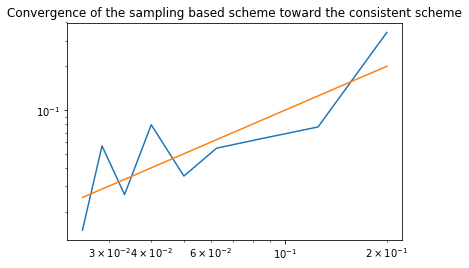

In [43]:
isamples=1./np.array(samples); plt.title("Convergence of the sampling based scheme toward the consistent scheme")
plt.loglog(isamples,errors, isamples,isamples);